# SEATTLE data analaysis

# Introduction 

The following project will investigate the shart term property market in the city of seattle also referred to as the Emerald city.
To conduct this investigation, the analysis will follow the CRISP-DM process which stands for Cross Industry Process for Data Mining.

Business Understanding

Based on the available data we will attempt to understand the following 

a) What are the trends in the listings and reviews over the years in the short term property market?

b) What specific locations and property types have the highest listings?

c) How have the prices changed over the years (nightly_prices,weekly_prices,monthly_prices)?

d) What is the price average in specific areas?

We will also model the nightly_price of listings in seattle.




# 2.Importing libraries

In [171]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#libraries required for the modelling
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler #
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

#mapping 
from keplergl import KeplerGl

#times series data handling 
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

#for visualizations
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline


# 3.Import the data 

In [172]:
import os
working_directory=os.getcwd()
print(working_directory)

/Users/lindomavimbela/Downloads/archive


In [173]:
df_calendar=pd.read_csv(working_directory +'/calendar.csv')
df_listings=pd.read_csv(working_directory +'/listings.csv')
df_reviews=pd.read_csv(working_directory +'/reviews.csv')

In [174]:
#we take a glimpes at the the different data sets loaded
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [175]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [176]:
df_listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [177]:
df_listings.isna().sum()

id                                    0
listing_url                           0
scrape_id                             0
last_scraped                          0
name                                  0
                                   ... 
cancellation_policy                   0
require_guest_profile_picture         0
require_guest_phone_verification      0
calculated_host_listings_count        0
reviews_per_month                   627
Length: 92, dtype: int64

# 4.Data Processing

# 4.1 Checking for missing data 

In [178]:
#validating the size of the data 
num_rows = df_listings.shape[0] #Provide the number of rows in the dataset
num_cols = df_listings.shape[1] #Provide the number of columns in the dataset

print(num_rows,num_cols)

3818 92


In [179]:
no_nulls = set(df_listings.columns[df_listings.isnull().mean()==0])#Provide a set of columns with 0 missing values.
no_nulls_view=len(no_nulls)/df_listings.shape[1] #percentage of columns with no_nulls compared to the total number of columns
no_nulls_view

#almost half of the columns in the data contain nulls

0.5108695652173914

In [180]:
missing_cols = set(df_listings.columns[df_listings.isnull().mean() >0.5])#set of columns with more than 50% of the values missing
missing_cols

{'license', 'monthly_price', 'security_deposit', 'square_feet'}

In [181]:
missing_cols = set(df_listings.columns[df_listings.isnull().mean() >0.75])#set of columns with more than 75% of the values missing
missing_cols

{'license', 'square_feet'}

In [15]:
# drop columns with more than 75% of the data missing
cols_to_drop = ['license','square_feet']  
df_list_new = df_listings.drop(cols_to_drop, axis=1)


We can already identify some columns that wont be necessary for the study considering we wont be applying natural language processing
Therefore we can drop the ff columns in our dataset.

In [182]:
cols_to_drop1 = ['host_url','listing_url','name','summary','last_scraped','space','description','neighborhood_overview','notes','transit','thumbnail_url','medium_url','picture_url','xl_picture_url','xl_picture_url','host_thumbnail_url','host_picture_url']
df_object_col_drop = df_list_new.drop(cols_to_drop1, axis=1)

In [183]:
df_object_col_drop.shape[1]

74

In [83]:
# we will now split the data into numerical and object type so we can analyse the rows and columns separately

# 4.2 Numerical Values

In [184]:
df_listing_new=df_object_col_drop
df_listing_new.describe()


,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,37.000000,12.150000




Creating a numeral values only dataset



In [187]:
num_vals=df_listing_new[['id','scrape_id','host_id','host_listings_count','host_total_listings_count','latitude','longitude','accommodates','bathrooms','bedrooms','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']]


Here we will fill all null vales with the mean for the numerical dataset. the decision to use the mean in this case is informed by the fact that the mean will give a better reflection of the missing values considering the size of the dataset


In [190]:
#handling nulls for the numerical data set by imputing with the mean value.

#mean function
fill_mean=lambda col: col.fillna(col.mean())
#fill the mean
num_vals1=num_vals.apply(fill_mean,axis=0)

In [191]:
num_vals1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           3818 non-null   int64  
 1   scrape_id                    3818 non-null   int64  
 2   host_id                      3818 non-null   int64  
 3   host_listings_count          3818 non-null   float64
 4   host_total_listings_count    3818 non-null   float64
 5   latitude                     3818 non-null   float64
 6   longitude                    3818 non-null   float64
 7   accommodates                 3818 non-null   int64  
 8   bathrooms                    3818 non-null   float64
 9   bedrooms                     3818 non-null   float64
 10  number_of_reviews            3818 non-null   int64  
 11  review_scores_rating         3818 non-null   float64
 12  review_scores_accuracy       3818 non-null   float64
 13  review_scores_clea

from above we can see that the total count of entries for each numerical column is now the same as the total count which means there are no longer any missing values

In [192]:
print(num_vals1.shape[0],num_vals.shape[1])

3818 18


from this we can pickup that price is not shown on the numericals dataset and this is the paramenter we want to model. this is due to the fact that price is a string in the data set because of the dollar($) sign before the price value.



In [199]:
def convert_price_to_float(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

In [200]:
df_listing_new['price'] = df_listing_new['price'].apply(convert_price_to_float).astype('float')


# 4.3 Visualizing numerical data

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'scrape_id'}>,
        <AxesSubplot:title={'center':'host_id'}>,
        <AxesSubplot:title={'center':'host_listings_count'}>,
        <AxesSubplot:title={'center':'host_total_listings_count'}>],
       [<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'accommodates'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>],
       [<AxesSubplot:title={'center':'beds'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'guests_included'}>,
        <AxesSubplot:title={'center':'minimum_nights'}>,
        <AxesSubplot:title={'center':'maximum_nights'}>],
       [<AxesSubplot:title={'center':'availability_30'}>,
        <AxesSubplot:title={'center':'availability_60'}>,
        <AxesSubplot:title={'center':'availability_90'}>,
        <AxesSubpl

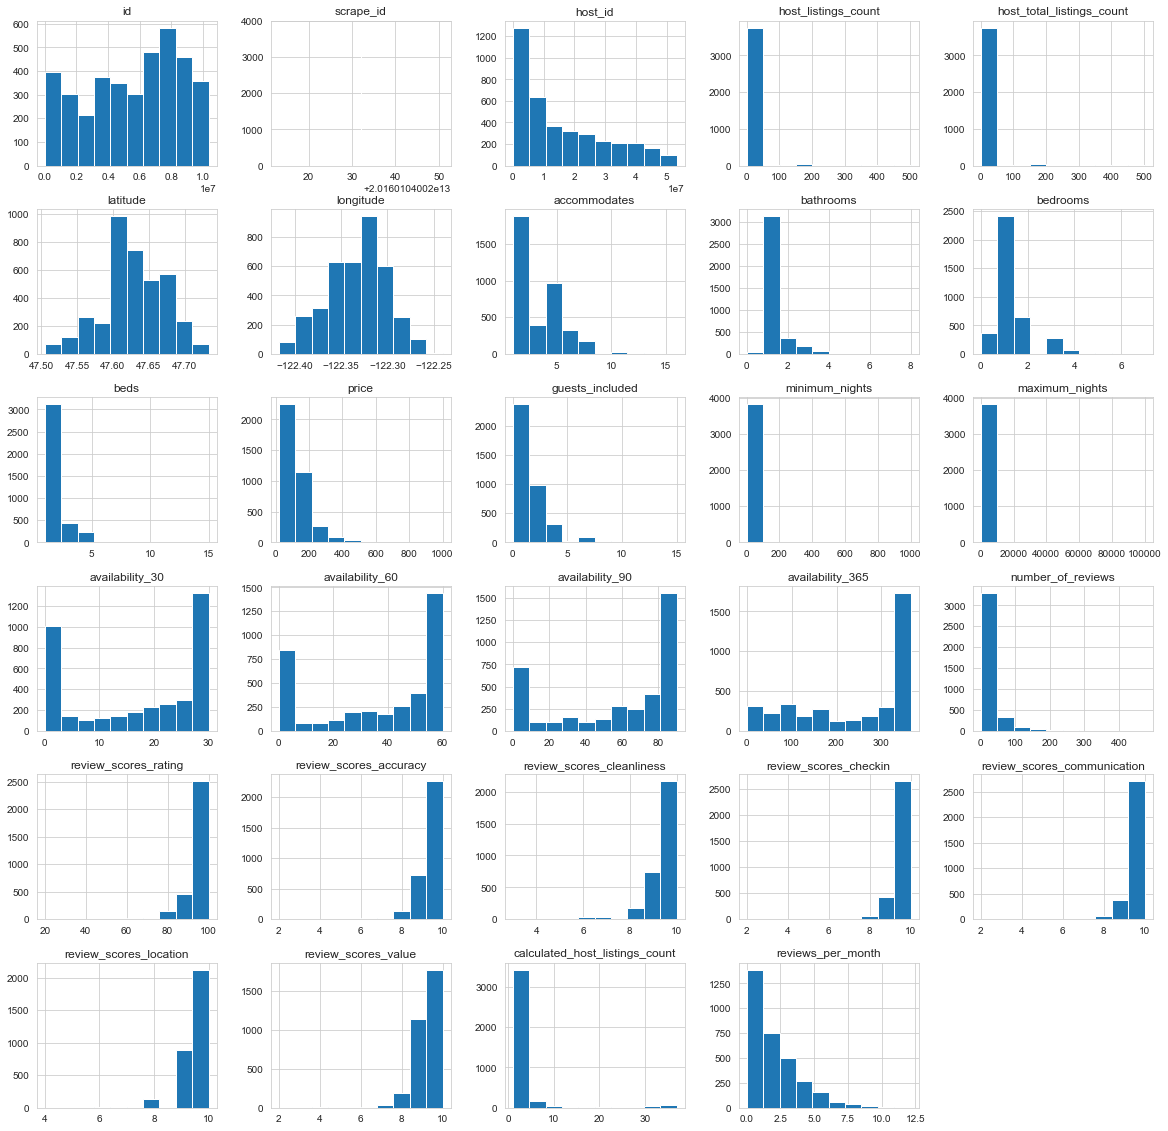

In [202]:
df_listing_new.hist(figsize=(20,20))

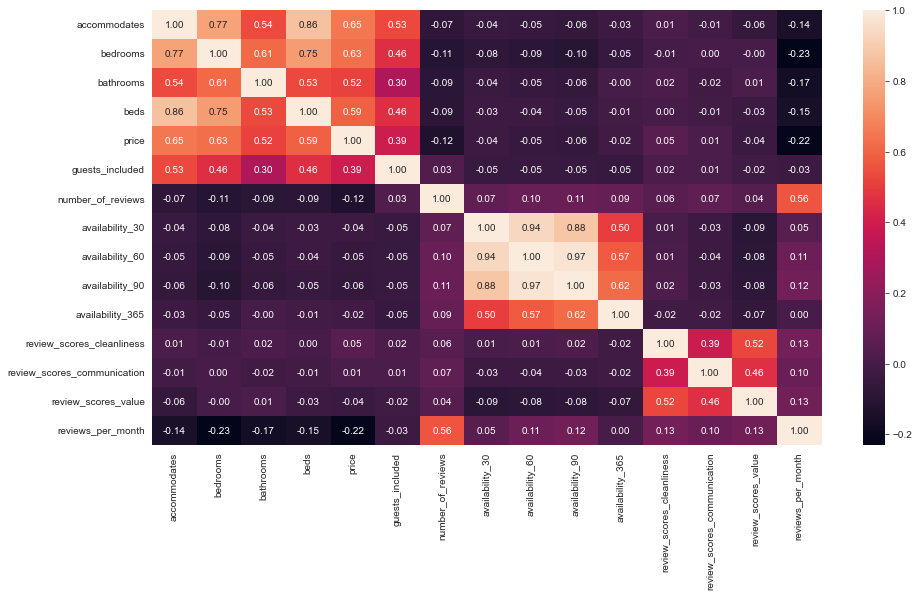

In [203]:
df_listing_num_vals=df_listing_new[['accommodates','bedrooms','bathrooms','beds','price','guests_included','number_of_reviews','availability_30','availability_60','availability_90','availability_365','review_scores_cleanliness','review_scores_communication','review_scores_value','reviews_per_month']]
plt.figure(figsize = (15,8))
sns.heatmap(df_listing_num_vals.corr(), annot=True, fmt=".2f");

# 4.4 Handling categorical data

In [204]:
obj_cat_df=df_listing_new.select_dtypes(include=['object']).copy()
obj_cat_df.shape[1]

45

In [205]:
#number of columns with no missing
np.sum(np.sum(obj_cat_df.isnull())/obj_cat_df.shape[0]==0)

25

In [206]:
np.sum(np.sum(obj_cat_df.isnull())/obj_cat_df.shape[0] > .5)

2

In [207]:
np.sum(np.sum(obj_cat_df.isnull())/obj_cat_df.shape[0] > .75)

0

In [208]:
#Pull a list of the column names of the categorical variables
cat_cols_lst = obj_cat_df.columns

def create_dummy_df(df_listing_new, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df_listing_new = pd.concat([df_listing_new.drop(col, axis=1), pd.get_dummies(df_listing_new[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df_listing_new

In [209]:
df_new = create_dummy_df(df_listing_new, cat_cols_lst, dummy_na=False) #Use your newly created function

# Show a header of df_new to check
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Columns: 12533 entries, id to require_guest_phone_verification_t
dtypes: float64(16), int64(13), uint8(12504)
memory usage: 46.4 MB


# 5.Modelling

The modelling process will be done as follows
1. we will first model price by only condering numerical values
2. We will then model the price by considering both numerical and categorical data 
3. we will then optimise the model through the standard Scaler method.

in each stage we will evaluate the perfomance of the model

# 5.1 Modelling with only numerical values

In [210]:
#Modelling with only numerical values to predict the price of an Airbnb

#mean function
fill_mean=lambda col: col.fillna(col.mean())
#fill the mean
fill_df=df_listing_num_vals.apply(fill_mean,axis=0)

#Split into explanatory and response variables
X = fill_df[['accommodates','bedrooms','bathrooms','beds','guests_included','number_of_reviews','availability_30','availability_60','availability_90','availability_365','review_scores_cleanliness','review_scores_communication','review_scores_value','reviews_per_month']]
y = fill_df['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 

#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))




'The r-squared score for the model using only quantitative variables was 0.5076087143709518 on 1146 values.'

# 5.2 Modelling with both Numerical and categorical values

In [212]:

#mean function
fill_mean=lambda col: col.fillna(col.mean())
#fill the mean
fill_df=df_new.apply(fill_mean,axis=0)

#Split into explanatory and response variables

X = fill_df
y = fill_df['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 


lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 

#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using both quantitative & categorical vars was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))



'The r-squared score for the model using both quantitative & categorical vars was 0.8197263977890695 on 1146 values.'

# 5.3 Optimising the model using standard scaler

In [213]:
# We make further enhancements on the model by using the standard scaler library from scickit learn

In [214]:

#mean function
fill_mean=lambda col: col.fillna(col.mean())
#fill the mean
fill_df=df_new.apply(fill_mean,axis=0)

#Split into explanatory and response variables

X = fill_df

scaler = MinMaxScaler()
ltr=scaler.fit(X)

y = fill_df['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

X_train=ltr.fit_transform(X_train)
X_test=ltr.fit_transform(X_test)

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 

#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using both quantitative & categorical vars was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using both quantitative & categorical vars was 0.8517464505112949 on 1146 values.'

# 6. Exploratory Data Analysis (EDA) and visualizations

Addressing the business questions 

# 6.1 What are the trends in the listings and reviews over the years in the short term property market?

In [215]:
#TIME SERIES DATA

df_listings['host_since'] = pd.to_datetime(df_listings['host_since'])
df_listings['first_review'] = pd.to_datetime(df_listings['first_review'])

df_listings["host_since"].min(), df_listings["host_since"].max()

(Timestamp('2008-11-10 00:00:00'), Timestamp('2016-01-03 00:00:00'))

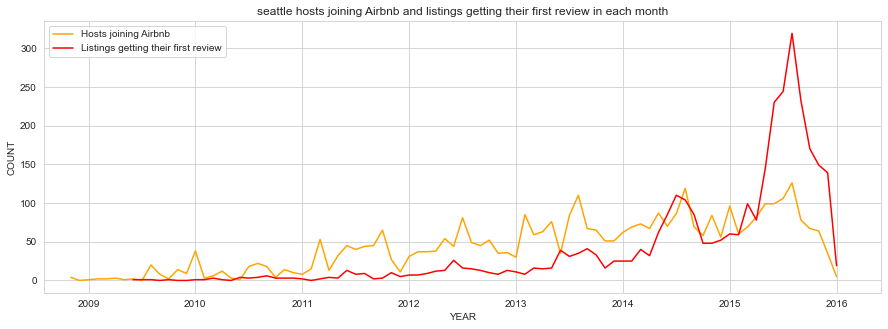

In [216]:
#Time series plots

plt.figure(figsize=(15,5))
df_listings.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
df_listings.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='red')


plt.title('seattle hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2008-08-21', '2016-06-20') 
plt.xlabel('YEAR')
plt.ylabel('COUNT')
plt.show()

In [217]:
df_listing_new.host_since=pd.to_datetime(df_listing_new.host_since)
df_listing_new.first_review=pd.to_datetime(df_listing_new.first_review)

In [219]:
df_listing_new.reset_index().set_index('host_since').resample('MS').size()
df_listing_new.reset_index().set_index('first_review').resample('MS').size()

first_review
2009-06-01      1
2009-07-01      1
2009-08-01      1
2009-09-01      0
2009-10-01      1
             ... 
2015-09-01    232
2015-10-01    170
2015-11-01    149
2015-12-01    139
2016-01-01     19
Length: 80, dtype: int64

In [220]:
ts_host_since = pd.DataFrame(df_listing_new.reset_index().set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df_listing_new.reset_index().set_index('first_review').resample('MS').size())


ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [221]:
#Plots the original time series and its decomposition into trend, seasonal and residual.
   
def decompose_time_series(df_listings, title=''):
# Decomposing the time series
    decomposition = seasonal_decompose(df_listings)
    
# Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
# Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df_listings, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

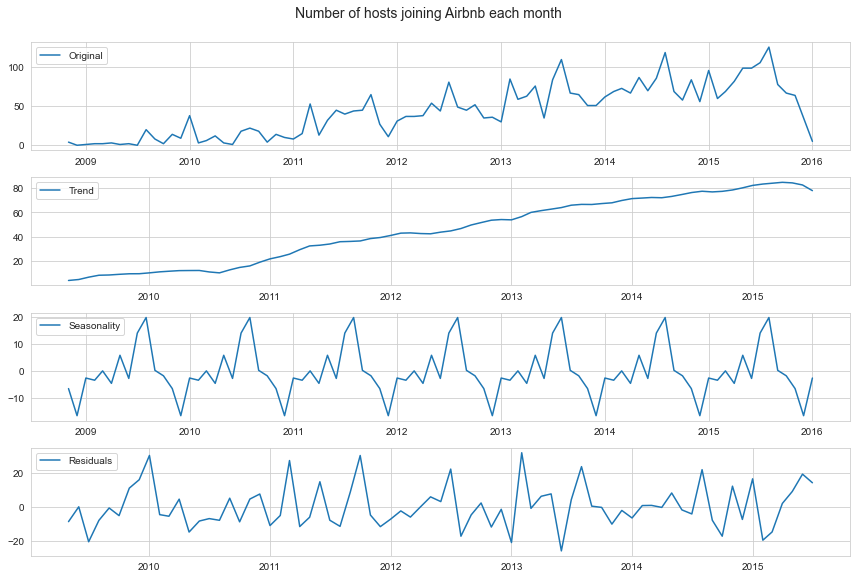

In [222]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

# 6.2 What specific locations and property types have the highest listings?

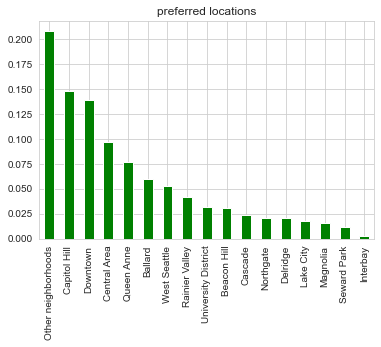

In [223]:
#we look at the listings related to the neighbourhood in seattle
neighbourhood_type = df_listing_new.neighbourhood_group_cleansed.value_counts()#Provide a pandas series of the counts for each Professional status

(neighbourhood_type/df_listing_new.shape[0]).plot(kind="bar",color='green');
plt.title("preferred locations");


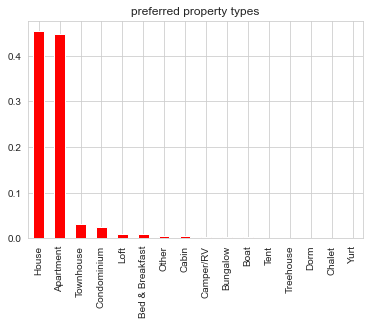

In [232]:
Property_type = df_listing_new.property_type.value_counts()

# we then look at the popular accomodation types in the same areas

(Property_type/df_listing_new.shape[0]).plot(kind="bar",color='red');
plt.title("preferred property types");

# from below we can tell that the two important accomodation types are apartments and houses.
# therefore we can potentially group the rest 

In [233]:
#GEOSPATIAL VISUALIZATION

cols_to_drop2 = ['host_since','first_review','last_review'] 
df_listing_map = df_listing_new.drop(cols_to_drop2, axis=1)

map_1 = KeplerGl()

map_1 = KeplerGl(height=500, data={"'Airbnb seattle'":df_listing_map})

map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={"'Airbnb seattle'":             id       scrape_id experiences_offered   host_id host_name  \
0…

In [234]:
map_1.save_to_html(file_name='seattle host listings.html')

Map saved to seattle host listings.html!


# 6.3 How have the prices changed over the years (nightly_prices,weekly_prices,monthly_prices)?

In [235]:
# show visualization linked to price overtime 

Text(0, 0.5, 'Price in Dollars($)')

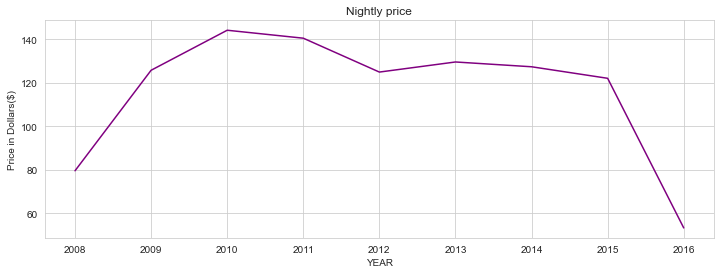

In [236]:
df_listing_new["year"] = df_listing_new["host_since"].dt.year
df_price_nbr=df_listing_new.groupby(['year']).mean()['price']
df_price_nbr.plot(figsize=(12,4),color='purple')
plt.title('Nightly price')
plt.xlabel('YEAR')
plt.ylabel('Price in Dollars($)')

In [237]:
df_object_col_drop['weekly_price'] = df_object_col_drop['weekly_price'].apply(convert_price_to_float).astype('float')
df_object_col_drop['monthly_price'] = df_object_col_drop['monthly_price'].apply(convert_price_to_float).astype('float')

Text(0, 0.5, 'monthly Price in Dollars($)')

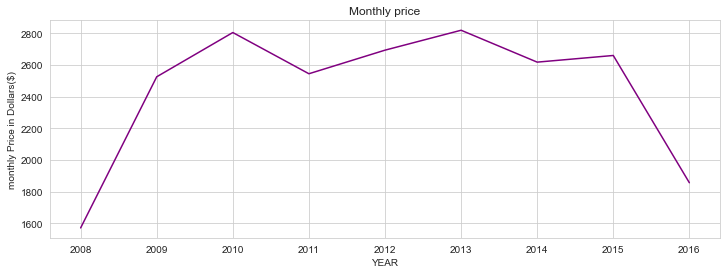

In [238]:
df_listing_new["month"] = df_listing_new["host_since"].dt.month
df_price_nbr=df_listing_new.groupby(['year']).mean()['monthly_price']
df_price_nbr.plot(figsize=(12,4),color='purple')
plt.title('Monthly price')
plt.xlabel('YEAR')
plt.ylabel('monthly Price in Dollars($)')

Text(0, 0.5, 'weekly Price in Dollars($)')

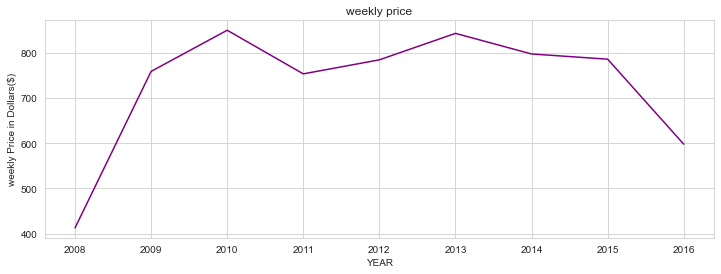

In [239]:
df_listing_new["month"] = df_listing_new["host_since"].dt.month
df_price_nbr=df_listing_new.groupby(['year']).mean()['weekly_price']
df_price_nbr.plot(figsize=(12,4),color='purple')
plt.title('weekly price')
plt.xlabel('YEAR')
plt.ylabel('weekly Price in Dollars($)')

# 6.4.What is the price average in specific areas?

In [240]:
df_listing_new["nightly_price"] = df_listing_new["price"]
neighbourhood=pd.pivot_table(df_listing_new,values=['nightly_price','host_listings_count','weekly_price','monthly_price'],index=['neighbourhood_group_cleansed'],
            aggfunc={'nightly_price': np.mean,
                     'weekly_price':np.mean,
                     'monthly_price':np.mean,
                     'host_listings_count':np.sum
                    }) 
neighbourhood.sort_values(by='host_listings_count',ascending='true')

,host_listings_count,monthly_price,nightly_price,weekly_price
neighbourhood_group_cleansed,,,,
Interbay,23.0,2160.454545,109.727273,713.636364
Delridge,106.0,1885.177215,83.278481,573.278481
Seward Park,131.0,1856.977273,108.477273,535.795455
Magnolia,139.0,2699.950820,177.672131,909.770492
Northgate,149.0,2089.450000,88.550000,503.187500
Cascade,310.0,3414.168539,140.101124,966.067416
Beacon Hill,333.0,2505.084746,94.669492,636.677966
West Seattle,440.0,2550.497537,141.359606,807.522167
Lake City,455.0,1987.000000,92.671642,542.373134


We can also look at the price distribution based on property types

In [241]:

accomodation_type=pd.pivot_table(df_listing_new,values=['nightly_price','host_listings_count','weekly_price','monthly_price'],index=['property_type'],
            aggfunc={'nightly_price': np.mean,
                     'weekly_price':np.mean,
                     'monthly_price':np.mean,
                     'host_listings_count':np.sum
                    }) 
accomodation_type.sort_values(by='host_listings_count',ascending='true')
accomodation_type.dropna(axis=0).sort_values(by='host_listings_count',ascending='true')

,host_listings_count,monthly_price,nightly_price,weekly_price
property_type,,,,
Yurt,1.0,2800.000000,100.000000,695.000000
Dorm,4.0,2457.000000,39.500000,1898.000000
Chalet,5.0,2325.000000,98.500000,587.500000
Treehouse,6.0,1581.333333,101.000000,546.666667
Boat,12.0,2836.875000,282.375000,1137.875000
Tent,15.0,3225.000000,54.000000,694.000000
Bungalow,16.0,2532.692308,115.615385,728.307692
Camper/RV,31.0,2886.615385,120.461538,605.923077
Cabin,41.0,2293.619048,104.666667,591.333333


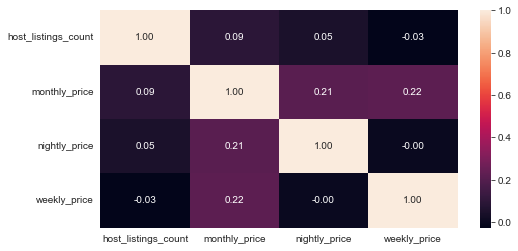

In [242]:
plt.figure(figsize = (8,4))
sns.heatmap(accomodation_type.corr(), annot=True, fmt=".2f");